In [1]:
with open('/content/drive/MyDrive/input.txt', 'r', encoding='utf-8') as f:
  text = f.read()

In [2]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [3]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [4]:
len(text)

1115394

In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# simplest for of tokenizer (character level)
s2i = {ch:i for i, ch in enumerate(chars)}
i2s = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [s2i[c] for c in s]
decode = lambda l: ''.join([i2s[i] for i in l])

print(encode("hii there"))
print(decode(encode("hii there")))
# look up better tokenizers like the ones ChatGPT, google uses

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
import torch

In [8]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [9]:
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [10]:
train_data.shape, val_data.shape

(torch.Size([1003854]), torch.Size([111540]))

In [11]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [12]:
'''
we can not feed into the transformer entire dataset which is computationally expensive and impractical.
We feed in random little chunks (block_size) to predict the label.
Also this breaking the entire dataset into block_size helps the transformer to see all the possible sequence of characters and its label.
e.g. the output below. This way when we sample from the trained transformer, even when we give 1 input, it can generate a output; since it has seen that kind of input and output mapping

NOTE: the transformer can only take inputs from length 1->block_size. Any input greater than block_size needs to truncated and re-fed as another input
'''
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
  context = x[:t+1]
  label = y[t]
  print(f"when input is {context} the target is: {label}")

when input is tensor([18]) the target is: 47
when input is tensor([18, 47]) the target is: 56
when input is tensor([18, 47, 56]) the target is: 57
when input is tensor([18, 47, 56, 57]) the target is: 58
when input is tensor([18, 47, 56, 57, 58]) the target is: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target is: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target is: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target is: 58


In [13]:
[i for i in range(8)]

[0, 1, 2, 3, 4, 5, 6, 7]

In [14]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
  # generate a small batch of data of inputs x and targets y
  data = train_data if split == 'train' else val_data
  ix = torch.randint(len(data) - block_size, (batch_size,))
  x = torch.stack([data[i:i+block_size] for i in ix])
  y = torch.stack([data[i+1:i+block_size+1] for i in ix])
  return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)
print('---------------')

for b in range(batch_size): # batch dimension
  for t in range(block_size): # time dimension
    context = xb[b, :t+1]
    target  = yb[b, t]
    print(f"when input is {context.tolist()} the target is: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
---------------
when input is [24] the target is: 43
when input is [24, 43] the target is: 58
when input is [24, 43, 58] the target is: 5
when input is [24, 43, 58, 5] the target is: 57
when input is [24, 43, 58, 5, 57] the target is: 1
when input is [24, 43, 58, 5, 57, 1] the target is: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target is: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target is: 39
when input is [44] the target is: 53
when input is [44, 53] the target is: 56
when input is [44, 53, 56] the target is: 1
when input is [44, 53, 56, 1] the target is: 58
when input is [44, 53, 

In [15]:
ix = torch.randint(len(train_data) - 8, (4,))
[data[i:i+block_size] for i in ix]
torch.stack([data[i:i+block_size] for i in ix])

tensor([[57, 43, 60, 43, 52,  1, 63, 43],
        [60, 43, 42,  8,  0, 25, 63,  1],
        [56, 42,  5, 57,  1, 57, 39, 49],
        [43, 57, 58, 63,  6,  1, 58, 46]])

In [16]:
torch.zeros((1,1), dtype=torch.long).shape

torch.Size([1, 1])

In [17]:
# @title ######simplest implementation using Bigram representation and jank
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)


# this simplest implementation of the model is ridiculus; since it is only a bigram model,
# so to predict next character it only uses the immediete previous character. But we are feeding it all context before the label,
# which are not being used. this is because current implementaion is written in a general way.
# we fed in increasing sizes of context, but then only looked at the very last character and used it to predict next character


# other words the token are not communicating with each other
class BigramLanguageModel(nn.Module):

  def __init__(self, vocab_size):
    super().__init__()
    # each token directly reads off the logits for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

  def forward(self, idx, targets=None):

    # idx and targets are both (B,T) tensor of integers
    logits = self.token_embedding_table(idx) # (B, T, C) batch, time, channel
    # this nn.Embedding has done all the intermediete work, that was done explicitly for 'makemore' model
    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape # the way we implemented logits, it gives (batch, Time, channel)
      # but pytorch cross entropy expects (B, C, T), basically it expects 'C' in the dim=1
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):
      # get the predictions
      # also when we run generate() it give only logits as (B,T,C) and loss=None
      logits, loss = self(idx) #self.forward(idx)
      #print(logits.shape)

      # focus only one the last time step
      logits = logits[:,-1,:] # becomes (B, C) # we pluck out the last element in 'T' dim, which are the labels of what comes next
      #print(logits.shape)

      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=1) # (B, C) # softmaxing accross 'T' dim
      #print(probs.shape)

      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

      # append sampled index to the running sequence
      idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
      #print(idx.shape)
    return idx


m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb) # xb->torch.Size([4, 8]), yb->torch.Size([4, 8])
print(logits.shape, loss.item()) # (B*T, C)-> torch.Size([4*8, 65])


# now since we know there are '65' characters/tokens, at initialization we know what the loss should be
# at init all '65' char should have equal probability, So neg log likelihood-> -ln(1/65)=4.1743872699
# loss.item() -> 4.878634929656982 ||| as we can see the loss we got is not exactly the same, and thus the model has some jitter/entropy and didn't learn correctly


# idx = torch.zeros((1,1), dtype=torch.long) -> feed in [0] to kick of generation, remember '0' was the element for 'new_line' character
# run idx through m.generate for 100 max_tokens, and then index into the 'B' dimension[0] to pluck out the elements from each batch 'B'
print(decode(m.generate(torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([32, 65]) 4.878634929656982

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


In [18]:
# create a Pytorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3) # SGD->stochastic gradient descent (previously used)

In [19]:
batch_size = 32
for steps in range(10000):

  # sample a batch of data
  xb, yb = get_batch('train')

  # evaluate the loss
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True) # setting parameters previous gradients to None
  loss.backward()  # getting gradients
  optimizer.step() # using gradients to update parameters

# here we are only optimizing(by backprop) the embedding table (which was initialized randn) since we didn't add any other layer
print(loss.item())

2.5727508068084717


In [20]:
print(decode(m.generate(torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZAnde.
athave l.
KEONH:
ARThanco be y,-hedarwnoddy scace, tridesar, wnl'shenous s ls, theresseys
PlorseelapinghiybHen yof GLUCEN t l-t E:
I hisgothers je are!-e!
QLYotouciullle'z


# The mathematical trick in self-attention

In [21]:
# the simplest implementation didn't have tokens communicating with each other. But we want the tokens to communicate,
# and communicate in a specific way. Specifically, token=4 should not communicate with token=5,6,7 since these are the future token.
# rather token=4 should communicate with all previous tokens=3,2,1,0.


# consider the following toy example
torch.manual_seed(1337)
B,T,C = 4,8,2
x = torch.randn(B,T,C) # batch, time, channels
x.shape

torch.Size([4, 8, 2])

In [22]:
# @title #####version1 -- average
#very weak interaction system. Averaging current and all previous tokens (T dim) through the channel dim for all batch dim.

# xbow->bag of words; we want x[b,t] = mean_{i<=t} x [b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
  for t in range(T):
    xprev = x[b,:t+1] # (t,C)
    xbow[b,t] = torch.mean(xprev, dim=0)

In [23]:
x, xprev, torch.mean(xprev, dim=0)

(tensor([[[ 0.1808, -0.0700],
          [-0.3596, -0.9152],
          [ 0.6258,  0.0255],
          [ 0.9545,  0.0643],
          [ 0.3612,  1.1679],
          [-1.3499, -0.5102],
          [ 0.2360, -0.2398],
          [-0.9211,  1.5433]],
 
         [[ 1.3488, -0.1396],
          [ 0.2858,  0.9651],
          [-2.0371,  0.4931],
          [ 1.4870,  0.5910],
          [ 0.1260, -1.5627],
          [-1.1601, -0.3348],
          [ 0.4478, -0.8016],
          [ 1.5236,  2.5086]],
 
         [[-0.6631, -0.2513],
          [ 1.0101,  0.1215],
          [ 0.1584,  1.1340],
          [-1.1539, -0.2984],
          [-0.5075, -0.9239],
          [ 0.5467, -1.4948],
          [-1.2057,  0.5718],
          [-0.5974, -0.6937]],
 
         [[ 1.6455, -0.8030],
          [ 1.3514, -0.2759],
          [-1.5108,  2.1048],
          [ 2.7630, -1.7465],
          [ 1.4516, -1.5103],
          [ 0.8212, -0.2115],
          [ 0.7789,  1.5333],
          [ 1.6097, -0.4032]]]),
 tensor([[ 1.6455, -0.8030],

In [24]:
x[0], xbow[0]

(tensor([[ 0.1808, -0.0700],
         [-0.3596, -0.9152],
         [ 0.6258,  0.0255],
         [ 0.9545,  0.0643],
         [ 0.3612,  1.1679],
         [-1.3499, -0.5102],
         [ 0.2360, -0.2398],
         [-0.9211,  1.5433]]),
 tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]))

In [25]:
# @title #####version 2 -- matrix multiplication system
wei = torch.tril(torch.ones(T,T))
wei = wei / wei.sum(1, keepdim=True)
print(wei)
xbow2 = wei @ x # (T,T) @ (B,T,C) ---broadcast--> (B,T,T) @ (B,T,C) ---> (B,T,C)  '@ here is batched matrix multiplication'
print(xbow[0],'\n', xbow2[0])
torch.allclose(xbow, xbow2)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]]) 
 tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.

False

In [26]:
torch.manual_seed(42)
#a = torch.ones(3,3)
a = torch.tril(torch.ones(3,3)) # make a upper triangular tensor
a = a / torch.sum(a, 1, keepdim=True) # normalizing through dim=1 or accross row of 'a'
# now if we see the tensor->'a' ; we will understand that (a @ b) will essentially average the 'b' column values by using 'a'
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=','\n',a)
print('b=','\n',b)
print('c=','\n',c)

a= 
 tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b= 
 tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
c= 
 tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [27]:
# @title #####version 3: use softmax
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T)) # think of it as interaction strength which tells us how much of the token from the past we want to aggregate
# these weights are not going to be zero forever. The token weight/ wei will look at each other, find affinity to other tokens, and change its(wei) values
wei = wei.masked_fill(tril == 0, float('-inf')) # tells us which tokens can interact with each other, and which can not; future can not communicate with past
wei = F.softmax(wei, dim=1)
xbow3 = wei @ x # (T,T) @ (B,T,C) --> (B,T,T) @ (B,T,C) --> (B,T,C)
torch.allclose(xbow, xbow3)

False

In [28]:
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [29]:
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
print(wei)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [30]:
wei = F.softmax(wei, dim=-1)
# softmax-> exp()/sum(exp()) -> and exp(0)=1 and exp(-inf)=0
# thus softmax basically works as normalizer here
wei, wei.shape

(tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
         [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
         [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
         [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]]),
 torch.Size([8, 8]))

In [31]:
x.shape ,x

(torch.Size([4, 8, 2]),
 tensor([[[ 0.1808, -0.0700],
          [-0.3596, -0.9152],
          [ 0.6258,  0.0255],
          [ 0.9545,  0.0643],
          [ 0.3612,  1.1679],
          [-1.3499, -0.5102],
          [ 0.2360, -0.2398],
          [-0.9211,  1.5433]],
 
         [[ 1.3488, -0.1396],
          [ 0.2858,  0.9651],
          [-2.0371,  0.4931],
          [ 1.4870,  0.5910],
          [ 0.1260, -1.5627],
          [-1.1601, -0.3348],
          [ 0.4478, -0.8016],
          [ 1.5236,  2.5086]],
 
         [[-0.6631, -0.2513],
          [ 1.0101,  0.1215],
          [ 0.1584,  1.1340],
          [-1.1539, -0.2984],
          [-0.5075, -0.9239],
          [ 0.5467, -1.4948],
          [-1.2057,  0.5718],
          [-0.5974, -0.6937]],
 
         [[ 1.6455, -0.8030],
          [ 1.3514, -0.2759],
          [-1.5108,  2.1048],
          [ 2.7630, -1.7465],
          [ 1.4516, -1.5103],
          [ 0.8212, -0.2115],
          [ 0.7789,  1.5333],
          [ 1.6097, -0.4032]]]))

In [32]:
# @title #####version 4: self-attention
torch.manual_seed(1337)
B,T,C = 4,8,32
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
'''
# previously we initialized wei with all zeros(a uniform initialization). But some tokens might have strong affinities for specific tokens
# so this 'affinity' tensor wei should not be uniform, rather represent the affinities between tokens
# first we say every token emits a 2-d vector of keys and queries; key-> what do I contain, query-> what am I looking for
# the way we get affinities between tokens is, a dot product between the keys and queries
# so my tokens query dot products with all the other keys of previous tokens.
# now If my query and any of the keys are similarly arranged, it will give out a high value for the corresponding positions and becomes our wei(affinity representation tensor)
'''
key = nn.Linear(C, head_size, bias=False) # key-> what do I contain # (32,16)
query = nn.Linear(C, head_size, bias=False) # query-> what am I looking for # (32,16)
value = nn.Linear(C, head_size, bias=False)
k = key(x) #  indexing into (C,16) with [B,T,C] ---> (B,T,16)
q = query(x) #  indexing into (C,16) with [B,T,C] ---> (B,T,16)
wei = q @ k.transpose(-2,-1) # (B,T,16) @ (B,16,T) ----> (B,T,T)
# thus wei is not intiatized uniformly anymore but in a data dependent manner and preserves the affnity between tokens/nodes

tril = torch.tril(torch.ones(T,T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf')) # <---- THIS IS A TRANSFORMER DECODER BLOCK  # removing this makes it an encoder block
# !!THERE IS ALSO TRANSFORMER ENCODER BLOCK USED IN 'cross-attention'
wei = F.softmax(wei, dim=-1) # (B,T,T)

v = value(x) # (C,16),[B,T,T]->(B,T,16)adding another linear layer which will output the values we will finally aggregate, instead of raw 'x'
'''for a single head-->
we can think of 'x' as private information to this token. so i'm a 5th token and i've this identity; this info is kept in vector 'x'
now 'x' will emit-> heres what i'm interested in(query), heres what i have(key), and if you find me interesting heres what i will communicate to you
and this all is stored in 'v'; then v gets aggregated with wei
'''

out = wei @ v # this line does the actual average of present token wrt all past tokens
# and thus the weighted aggregation(out) is a function in a data-dependent manner between the keys and queries of the tokens/nodes
# (B,T,T) @ (B,T,16)->(B,T,16)
# if we don't use 'out = wei @ v', instead use 'out = wei @ x', we will have out=(B,T,32); this shouldn't? be a problem for single head
# but for multiple heads where we want to the information to flow indepenently and concatanate, this 'v' must be used

# torch.Size([4, 8, 32]) previously without v = value(x)
out.shape

torch.Size([4, 8, 16])

In [33]:
k.shape,wei.shape,v.shape

(torch.Size([4, 8, 16]), torch.Size([4, 8, 8]), torch.Size([4, 8, 16]))

In [34]:
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [35]:
wei

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
         [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
         [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
         [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1687, 0.8313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2477, 0.0514, 0.7008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4410, 0.0957, 0.3747, 0.0887, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0069, 0.0456, 0.0300, 0.7748, 0.1427, 0.0000, 0.0000, 0.0000],
         [0.0660, 0.089

In [36]:
# @title #####explanation how the key and queries find affinities
'''
# we see here the 8th token and 4th token have high values
# this 8th token knows what content(char) it has and knows its position(8th)
# and based on its knowledge of content and position, it makes a query
# e.g query (hey i'm a vowel at 8th position and i'm looking for specific kind of char upto 4th postion)
# and then all the tokens/nodes get to emit keys and maybe one of the channels emit i'm that specific char and i'm upto position 4
# and that key will have high value on that specific channel; that is how when ->query @ key-> they find each other and create a high affinity
# and when they have a high affinity(high value); the softmax will aggregate a lot the keys information into my position(query)
# thus I'll get to learn a lot about it
'''
print(wei[0])
wei[0][7]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)


tensor([0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391],
       grad_fn=<SelectBackward0>)

In [ ]:
 out

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights. This attention mechanism in principal can be used in any sort data represented by directed graph
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other. Think of it as 4 seperate pools/batchs of 8, where the 8's only talk to each other in every pool.
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

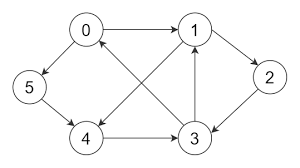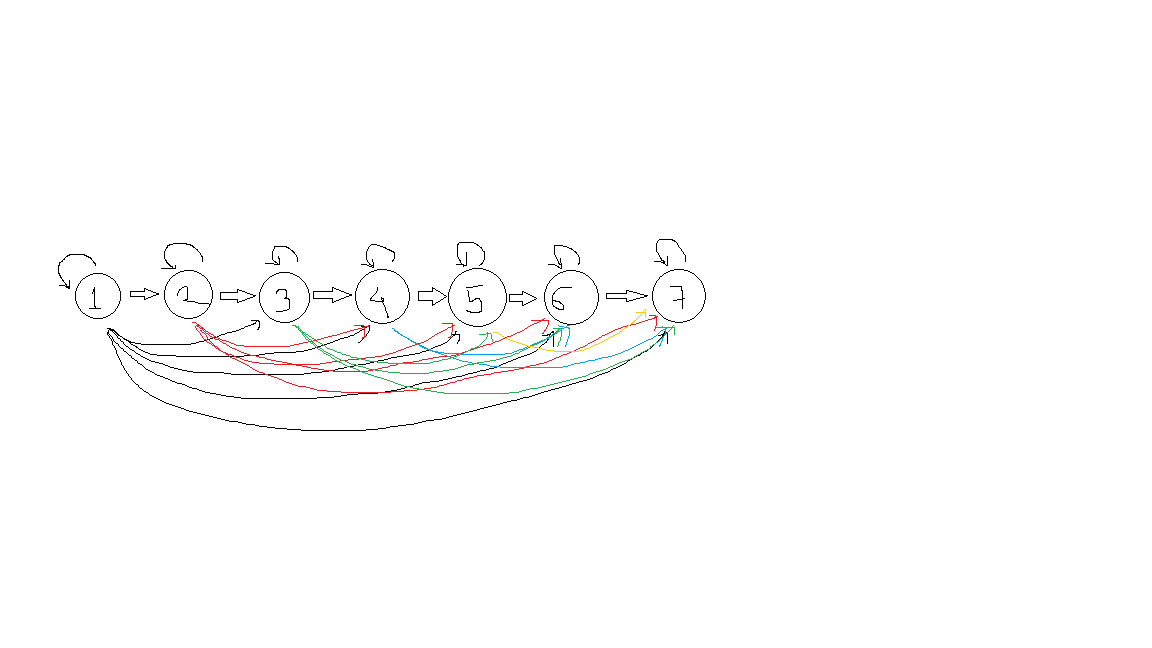

In [38]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) #* head_size**-0.5

In [39]:
k.var(), q.var(), wei.var()

(tensor(1.0449), tensor(1.0700), tensor(17.4690))

In [40]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5 # this /sqrt(head_size) is done to normalize wei !!important

In [41]:
k.var(), q.var(), wei.var() # look at the wei.var(); at initialization if wei.var() is too big(not diffuse),
                            # the softmax(exp()) will make it converge towards one-hot(1's)

(tensor(0.9006), tensor(1.0037), tensor(0.9957))

In [43]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [44]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [ ]:
batch_size = 4
block_size = 8
n_embd = 32
head_size = 16
vocab_size = len(s2i)
class Head(nn.Module):
    """" one head of self-attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False) # w(16,32) or w(8,32) (head_size, n_emb) ||weights->(out_feature, in_feature)
        self.query = nn.Linear(n_embd, head_size, bias=False) # w(16,32) (head_size, n_emb)
        self.value = nn.Linear(n_embd, head_size, bias=False) # w(16,32) (head_size, n_emb)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size))) # (T,T)(8,8)
        # 'tril' is not a parameter in the pytorch module. To assign it to the module we have to add it using register_buffer
    def forward(self, x):
        B,T,C = x.shape # 4,8,32
        #print('wewew',self.key.weight.shape)
        k = self.key(x) # (4,8,32) @ (16,32).T -> B,T,head_size=16 ->(4,8,16) || (4,8,32) @ (8,32).T ->(4,8,8)
        print('k',k.shape)
        q = self.query(x) # B,T,head_size=16 or 8 ||(4,8,32) @ (8,32).T ->(4,8,8)
        print('q',q.shape)
        # compute attention scores ('affinities')
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B,T=8,C=8) @ (B,C=8,T=8) --> (B,T,T) # scaled attention
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # (B,T,T)

        wei = F.softmax(wei, dim=-1) # (B,T,T)
        # perform the weighted aggregation of the values
        v = self.value(x) #(B,T,head_size=16)

        out = wei @ v # (B,T,head_size=16 or 8)
        print(out.shape)
        return out

class MultiHeadAttention(nn.Module):
    """" multiple heads of self-attention in parallel"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim=-1) # concat along channel dim(-1), so 4 heads of size 8 will give C=32

class FeedForward(nn.Module):
    """ a simple liner layer followed by a non-linearity"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of head we'd like
        super().__init__()
        head_size = n_embd//n_head
        self.sa = MultiHeadAttention(n_head, head_size) # communication
        self.ffwd = FeedForward(n_embd)  # computation

    def forward(self, x):
        x = self.sa(x)
        x = self.ffwd(x)
        return x

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        #self.sa_head = Head(n_embd)
        #self.sa_head = MultiHeadAttention(4, n_embd//4) # 4 heads(communication channels) of 8-dimensional self-attention
        #self.ffwd = FeedForward(n_embd)
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
        )
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # idx and targets are both (B,T) tensor of integers
        # each input token/char-int is embedded--> tok_emb
        tok_emb = self.token_embedding_table(idx) # (B 4, T 8, C=n_embd 32)

        # the position of token in that block_size of token gets embedded ->pos_emb
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, C=n_embd)
        #print('pos_emb', pos_emb.shape)
        x = tok_emb + pos_emb # (B, T, C=n_embd 32) by broadcasting
        #print('x', x.shape)
        # x = self.sa_head(x) # apply one/multiple head of self-attention.
        #                     #(B,T,C) (4,8,32) # concatanated 4 head of head_size=8 along 'C' dim thus(4,8,8)->(4,8,32)
        # print('x after head', x.shape)
        # x = self.ffwd(x) # (B,T,C)

        x = self.blocks(x) # (B,T,C)

        logits = self.lm_head(tok_emb) # (B, T, C=vocab_size)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens; because of we added positional encodings, idx can never be > block_size.
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond) # get the predictions
            logits = logits[:,-1,:] # focus only one the last time step (B, C)
            probs = F.softmax(logits, dim=1) # (B,C) apply softmax to get probabilities
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1) sample from the distribution
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1) append sampled index to the running sequence

        return idx

xb, yb = get_batch('train')
print('xb',xb.shape)
m = BigramLanguageModel()
logits, loss = m(xb, yb) # xb->torch.Size([4, 8]), yb->torch.Size([4, 8])
print(logits.shape, loss.item()) # (B*T, C)-> torch.Size([4*8, 65])

xb torch.Size([4, 8])
k torch.Size([4, 8, 8])
q torch.Size([4, 8, 8])
torch.Size([4, 8, 8])
k torch.Size([4, 8, 8])
q torch.Size([4, 8, 8])
torch.Size([4, 8, 8])
k torch.Size([4, 8, 8])
q torch.Size([4, 8, 8])
torch.Size([4, 8, 8])
k torch.Size([4, 8, 8])
q torch.Size([4, 8, 8])
torch.Size([4, 8, 8])
k torch.Size([4, 8, 8])
q torch.Size([4, 8, 8])
torch.Size([4, 8, 8])
k torch.Size([4, 8, 8])
q torch.Size([4, 8, 8])
torch.Size([4, 8, 8])
k torch.Size([4, 8, 8])
q torch.Size([4, 8, 8])
torch.Size([4, 8, 8])
k torch.Size([4, 8, 8])
q torch.Size([4, 8, 8])
torch.Size([4, 8, 8])
k torch.Size([4, 8, 8])
q torch.Size([4, 8, 8])
torch.Size([4, 8, 8])
k torch.Size([4, 8, 8])
q torch.Size([4, 8, 8])
torch.Size([4, 8, 8])
k torch.Size([4, 8, 8])
q torch.Size([4, 8, 8])
torch.Size([4, 8, 8])
k torch.Size([4, 8, 8])
q torch.Size([4, 8, 8])
torch.Size([4, 8, 8])
torch.Size([32, 65]) 4.383903980255127


In [ ]:
xb, yb = get_batch('train')
xb.shape, vocab_size

(torch.Size([4, 8]), 65)

In [ ]:
h = Head(head_size)
h.key.weight.shape

torch.Size([16, 32])

In [ ]:
key = nn.Linear(n_embd, head_size, bias=False)
print(key.weight.shape, xb.shape)
x = torch.randn((4,8,32))
print('x',x.shape)
k = key(x)
print('k',k.shape)

torch.Size([16, 32]) torch.Size([4, 8])
x torch.Size([4, 8, 32])
k torch.Size([4, 8, 16])


In [46]:
aa = torch.randn((4,8,8))
bb = torch.cat([aa for _ in range(4)], dim=-1)
aa.shape, bb.shape

(torch.Size([4, 8, 8]), torch.Size([4, 8, 32]))

In [59]:
import torch
import torch.nn as nn
from torch.nn import functional as F


#--------hyperparameters------------
batch_size = 32
block_size = 8
max_iters = 5000
eval_interval =300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32
head_size = 16
#---------------------------------
torch.manual_seed(1337)

with open('/content/drive/MyDrive/input.txt', 'r', encoding='utf-8') as f:
  text = f.read()

chars = sorted(list(set(''.join(text))))
vocab_size = len(chars)
s2i = {ch:i for i, ch in enumerate(chars)}
i2s = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [s2i[c] for c in s]
decode = lambda l: ''.join([i2s[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

# data loader
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data)-block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval() # turn off training, turn on eval
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters) # allocate space to log the losses
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X,Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # turn on training, turn off eval
    return out

class Head(nn.Module):
    """" one head of self-attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False) # (32,16) (n_emb, head_size)
        self.query = nn.Linear(n_embd, head_size, bias=False) # (32,16) (n_emb, head_size)
        self.value = nn.Linear(n_embd, head_size, bias=False) # (32,16) (n_emb, head_size)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size))) # (T,T)(8,8)
        # 'tril' is not a parameter in the pytorch module. To assign it to the module we have to add it using register_buffer
    def forward(self, x):
        B,T,C = x.shape # 4,8,32
        k = self.key(x) # (32,16)[4,8,32] -> B,T,head_size=16
        q = self.query(x) # B,T,head_size=16
        # compute attention scores ('affinities')
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B,T,T) @ (B,C,T) --> (B,T,T) # scaled attention
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # (B,T,T)

        wei = F.softmax(wei, dim=-1) # (B,T,T)
        # perform the weighted aggregation of the values
        v = self.value(x) #(B,T,head_size=16)
        out = wei @ v # (B,T,head_size=16)
        return out

class MultiHeadAttention(nn.Module):
    """" multiple heads of self-attention in parallel"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd) # this is for residual connection, called after the concatanation operation

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # residual block of self attention
        out = self.proj(out) # the projection back into the residual pathway/highway
         # a simple Linear layer to transform output of residual blocks back into the highway
        return out

class FeedForward(nn.Module):
    """ a simple liner layer followed by a non-linearity"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), # 4 * n_embd because attention paper said so and also in the next Linear layer
            # done to add extra computation power to the residual block; then scaling it back done when residual block add to the highway
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # projection layer going back into the residual highway
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of head we'd like
        super().__init__()
        head_size = n_embd//n_head
        self.sa = MultiHeadAttention(n_head, head_size) # communication
        self.ffwd = FeedForward(n_embd)  # computation
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # residual connections-> x=gradient highway, self.sa(x)=residual blocks of self attention
        x = x + self.ffwd(self.ln2(x))
        # layer-norm is added to 'x' "before" it is being fed into self-attention and feed-forward
        # here normaliztion is done across the C-dim(32), so the B and T act as batch-dimension of normalization
        return x

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        ##self.sa_head = Head(n_embd)
        #self.sa_head = MultiHeadAttention(4, n_embd//4) # 4 heads(communication channel of 8-dimensional self-attention)
        #self.ffwd = FeedForward(n_embd)
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            nn.LayerNorm(n_embd),
        )
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # idx and targets are both (B,T) tensor of integers
        # each input token/char-int is embedded--> tok_emb
        tok_emb = self.token_embedding_table(idx) # (B 4, T 8, C=n_embd 32)
        # the position of token in that block_size of token gets embedded ->pos_emb
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, C=n_embd)
        x = tok_emb + pos_emb # (B, T, C=n_embd) by broadcasting

        #x = self.sa_head(x) # apply one head of self-attention. (B,T,C)
        #x = self.ffwd(x) # (B,T,C)

        x = self.blocks(x) # (B,T,C)

        logits = self.lm_head(x) # (B, T, C=vocab_size)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens; because of we added positional encodings, idx can never be > block_size.
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond) # get the predictions
            logits = logits[:,-1,:] # focus only one the last time step (B, C)
            probs = F.softmax(logits, dim=1) # (B,C) apply softmax to get probabilities
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1) sample from the distribution
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1) append sampled index to the running sequence

        return idx



model = BigramLanguageModel()
m = model.to(device)

# create a pytorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch("train")

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

step 0: train loss 4.3103, val loss 4.3097
step 300: train loss 2.5220, val loss 2.5316
step 600: train loss 2.3644, val loss 2.3668
step 900: train loss 2.2732, val loss 2.2837
step 1200: train loss 2.1982, val loss 2.2302
step 1500: train loss 2.1681, val loss 2.2027
step 1800: train loss 2.1355, val loss 2.1766
step 2100: train loss 2.1030, val loss 2.1444
step 2400: train loss 2.0929, val loss 2.1360
step 2700: train loss 2.0808, val loss 2.1282
step 3000: train loss 2.0606, val loss 2.1100
step 3300: train loss 2.0393, val loss 2.1040
step 3600: train loss 2.0314, val loss 2.0995
step 3900: train loss 2.0300, val loss 2.0903
step 4200: train loss 2.0137, val loss 2.0714
step 4500: train loss 2.0096, val loss 2.0822
step 4800: train loss 1.9750, val loss 2.0678

But, agn cans't thile quen then, and thee.

For Wherely our low Set say.

FRI CIONCBET:
Where of RIORD RINAR DUF:
A dePed wart
Here, archtre;
Ar,
Il not; repon;
A lis buk pop.

ROMENIUS:
He? Bong;'t live all it my his him,


In [55]:
# @title #####Batch-norm to Layer-Norm
# commented out the stuff BatchNorm1d needed because it was normalizing across multiple examples in a batch.
# If normalization is not done across multiple examples but across each examples themselves, then its layer norm
# and LayerNorm does not need to keep track of stuff, since its not coupling several examples togather
# and it also doesn't care if it's training or eval mode.
# and we can apply this layer norm through out our model
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    #self.momentum = momentum
    #self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    #self.running_mean = torch.zeros(dim)
    #self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    #if self.training:
      # xmean = x.mean(0, keepdim=True) # batch mean
      # xvar  = x.var(0, keepdim=True, unbiased=True) # batch variance
    xmean = x.mean(1, keepdim=True) # layer mean
    xvar  = x.var(1, keepdim=True, unbiased=True) # layer variance
    # else:
    #   xmean = self.running_mean
    #   xvar  = self.running_var

    xhat = (x - xmean)/torch.sqrt(xvar+self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # # update the buffers
    # if self.training:
    #   with torch.no_grad():
    #     self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
    #     self.running_var  = (1-self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = BatchNorm1d(100)
x = torch.randn(32,100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [50]:
x[:,0].mean(), x[:,0].std() # mean, std of one feature across all batch inputs  (batch-norm)

(tensor(7.4506e-09), tensor(1.0000))

In [51]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features # these rows are not normalized by default (batch-norm)

(tensor(0.0411), tensor(1.0431))

In [56]:
x[:,0].mean(), x[:,0].std() # mean, std of one feature across all batch inputs  (layer-norm)

(tensor(0.1469), tensor(0.8803))

In [57]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features (layer-norm) # now the normalization is occuring across the rows

(tensor(-9.5367e-09), tensor(1.0000))

In [61]:
# @title #####dropout
'''
Dropout is added to help prevent overfitting to data by shutting done some connections randomly
Dropout takes your neural net and every forward & backward pass shuts(sets to 0) of some subset of neurons, and trains without them/those connections

And since what is being dropped out is changing every forward and backward pass, the NN ends up training an ensemble of sub-networks and at test time all the neurons are fully enabled
and all of those sub-networks are merged into a single ensemble.

This is basically a regularization method
'''
print("dropout")

dropout
